In [1]:
%matplotlib inline

import matplotlib
matplotlib.use('Agg')

from matplotlib import rc
rc('text', usetex=False)
matplotlib.rcParams['svg.fonttype'] = 'none'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import patches as mpatches
from collections import OrderedDict, defaultdict
import seaborn as sns
sns.set_style("ticks")
# sns.set_context("talk", font_scale=1.4)

from tqdm import tnrange, tqdm_notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


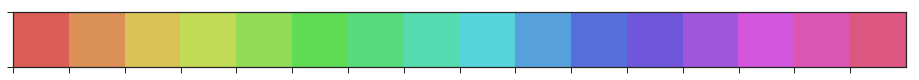

In [2]:
sns.set_style("ticks")
# sns.set_context("talk", font_scale=1.4)

sns.palplot(sns.color_palette("hls", 16))
colors = sns.color_palette("hls", 16)
density_colors = [colors[0], colors[9], 'black']

# Plot RBP map (raw density)

In [3]:
import sys
sys.path.insert(0, '/home/bay001/projects/codebase/rbp-maps/maps/')
from density import Map
from density import ReadDensity
from density import normalization_functions
from plotter import Plotter
from density import LineObject as dline

def get_lines(d, c=0.95):
    density_incl = dline.LineObject(
        event_matrix=pd.read_table(d['included']['matrix'], sep=',', index_col=0),
        annotation='Included upon knockdown',
        conf=c,
        color=d['included']['color'],
        min_event_threshold=100
    )
    density_excl = dline.LineObject(
        event_matrix=pd.read_table(d['excluded']['matrix'], sep=',', index_col=0),
        annotation='Excluded upon knockdown',
        conf=c,
        color=d['excluded']['color'],
        min_event_threshold=100
    )
    density_bg = dline.LineObject(
        event_matrix=pd.read_table(d['background']['matrix'], sep=',', index_col=0),
        annotation='Native cassettes',
        conf=c,
        color=d['background']['color'],
        min_event_threshold=100
    )
    return density_incl, density_excl, density_bg

In [4]:
import matplotlib

def _remove_outliers(df, conf=0.95):
    """
    Sets the means and standard error values after outlier
    removal. Returns dataframe. Replaces _get_means_and_sems.

    Parameters
    ----------
    df : pandas.DataFrame
        table of densities or values
    conf : float
        keep {conf}% of densities present at every given position

    Returns
    -------

    merged : pandas.DataFrame
        dataframe of outlier-removed events
        (masked) with the same shape as the input. 
        
    """

    merged = pd.DataFrame(index=df.index)
    progress = tnrange(df.shape[1])
    for col, row in df.iteritems():
        single_col = df[col].dropna()
        single_col = single_col.sort_values()
        nums = len(single_col)
        droppercent = (1 - conf) / 2.0
        dropnum = int(nums * droppercent)
        if dropnum > 0:
            single_col = single_col[dropnum:-dropnum]
        merged = pd.merge(merged, pd.DataFrame(single_col), how='left', left_index=True, right_index=True)
        progress.update(1)
    assert merged.shape[0] == df.shape[0]
    return merged

def plot_heatmap(df, font_size=8):
    sns.set(font_scale=1)
    r1 = df.iloc[:,:350]
    r2 = df.iloc[:,350:700]
    r3 = df.iloc[:,700:1050]
    r4 = df.iloc[:,1050:]
    vmin = min(df.min())
    vmax = max(df.max())
    regions = [r2, r3]

    gs_hm = gridspec.GridSpec(
                ncols=2, nrows=1, width_ratios=[1, 1]
    )
    f = plt.figure(figsize=(2, 2))
    plot_axs = []
    
    for i in range(0, 2):
        plot_axs.append(f.add_subplot(gs_hm[i]))
        
        if i < 3:

            sns.heatmap(
                regions[i], 
                xticklabels=False, 
                yticklabels=False, 
                ax=plot_axs[i], 
                vmin=vmin, 
                vmax=vmax,
                cbar=False,
            )
        else:
            cb = matplotlib.colorbar.ColorbarBase(ax=plot_axs[i], )
            cb.ax.tick_params(labelsize=font_size)

            sns.heatmap(
                regions[i], 
                xticklabels=False, 
                yticklabels=False, 
                ax=plot_axs[i], 
                vmin=vmin, 
                vmax=vmax,
                # cbar=True,
            )
            plot_axs[i].tick_params(labelsize=font_size)


In [5]:
FONTSIZE=8
mag = 1

def bulk_lw_adjuster(ax, lw=1):
        for ln in ax.lines:
            ln.set_linewidth(lw)
            
def plot_two_panel(incl, excl, bg, mag, read_ymin, read_ymax, output_file, label):
    fig = plt.figure(figsize=(4*mag, 1*mag))
    full_grid = gridspec.GridSpec(1, 2, height_ratios=[1], )

    map_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[0, 1:3])

    read_map_regions = [plt.subplot()]*4

    for i in range(1,3):
        read_map_regions[i] = (plt.subplot(map_row[i-1:i]))

    density_plotter = Plotter._SEPlotter(lines=[incl, excl, bg], num_regions=4)
    read_map_regions = density_plotter.plot(read_map_regions, None)
    density_plotter.renumber_axes(2, read_map_regions)

    # RDPlotter.plot_se([density_incl, density_excl], read_map_regions, density_colors) # density_bg
    # read_map_regions = Plotter.plot_se([peak_incl, peak_excl], 'tmp.out') # peak_bg

    # despine stuff
    for region in read_map_regions[1:3]:
        sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
        # region.yaxis.set_visible(False)

    read_map_regions[1].set_ylabel(label, size=FONTSIZE)
    read_map_regions[2].yaxis.set_visible(False)

    # read_ymin = 0
    # read_ymax = 0.5

    for ax in read_map_regions:
        ax.tick_params(labelsize=FONTSIZE)
        ax.set_ylim(read_ymin, read_ymax)
        bulk_lw_adjuster(ax)
    
    if read_ymin != 0 and read_ymax != 0:
        read_map_regions[1].yaxis.set_ticks([read_ymin, 0, read_ymax])
        read_map_regions[1].yaxis.set_ticklabels([read_ymin, '0', read_ymax])
    else:
        read_map_regions[1].yaxis.set_ticks([read_ymin, read_ymax])
        read_map_regions[1].yaxis.set_ticklabels([read_ymin, read_ymax])
    
    for i in range(0, len(read_map_regions)):
        renumber_axes(i, read_map_regions)
    read_map_regions[1].yaxis.set_visible(True)
    sns.despine(ax=read_map_regions[1], top=True, left=False, right=True)
    read_map_regions[1].axvline(350, alpha=0.3, linestyle=':', linewidth=0.5) # What why doesn't this line show up??? Produce it manually...
    

    fig.savefig(output_file)
    # plt.close()
    
def plot_four_panel(incl, excl, bg, mag, read_ymin, read_ymax, output_file, label):
    fig = plt.figure(figsize=(4*mag, 1*mag))
    full_grid = gridspec.GridSpec(1, 4, height_ratios=[1], )

    map_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[0, 1:4])

    read_map_regions = [plt.subplot()]*4

    for i in range(4):
        read_map_regions[i] = (plt.subplot(map_row[i:i+1]))

    density_plotter = Plotter._SEPlotter(lines=[incl, excl, bg], num_regions=4)
    read_map_regions = density_plotter.plot(read_map_regions, None)
    density_plotter.renumber_axes(2, read_map_regions)

    # RDPlotter.plot_se([density_incl, density_excl], read_map_regions, density_colors) # density_bg
    # read_map_regions = Plotter.plot_se([peak_incl, peak_excl], 'tmp.out') # peak_bg

    # despine stuff
    for region in read_map_regions[1:3]:
        sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
        # region.yaxis.set_visible(False)
        
    sns.despine(ax=read_map_regions[0], top=True, left=False, right=True, bottom=False)
    sns.despine(ax=read_map_regions[3], top=True, left=True, right=False, bottom=False)

    read_map_regions[0].set_ylabel(label, size=FONTSIZE)
    read_map_regions[3].yaxis.set_visible(False)

    # read_ymin = 0
    # read_ymax = 0.5

    for ax in read_map_regions:
        ax.tick_params(labelsize=FONTSIZE)
        ax.set_ylim(read_ymin, read_ymax)
        bulk_lw_adjuster(ax)
        if read_ymin != 0 and read_ymax != 0:
            ax.yaxis.set_ticks([read_ymin, 0, read_ymax])
            ax.yaxis.set_ticklabels([read_ymin, '0', read_ymax])
        else:
            ax.yaxis.set_ticks([read_ymin, read_ymax])
            ax.yaxis.set_ticklabels([read_ymin, read_ymax])
    for i in range(0, len(read_map_regions)):
        renumber_axes(i, read_map_regions)
    # read_map_regions[1].yaxis.set_visible(True)
    # sns.despine(ax=read_map_regions[1], top=True, left=False, right=True)
    # read_map_regions[1].axvline(350, alpha=0.3, linestyle=':', linewidth=0.5) # What why doesn't this line show up??? Produce it manually...
# incl_peak_patch = mpatches.Patch(color=peak_colors[0], label='Included upon KD (Peak)')
# excl_peak_patch = mpatches.Patch(color=peak_colors[1], label='Excluded upon KD (Peak)')
# incl_density_patch = mpatches.Patch(color=density_colors[0], label='Included upon KD (Density)')
# excl_density_patch = mpatches.Patch(color=density_colors[1], label='Excluded upon KD (Density)')

# leg = read_map_regions[0].legend(
#     bbox_to_anchor=(2.5, -1.3), loc=1, mode="expand",
#     handles=[incl_density_patch, excl_density_patch, incl_peak_patch, excl_peak_patch],
#     borderaxespad=0., ncol=2, fontsize=FONTSIZE
# )
    
    fig.savefig(output_file)
    # plt.close()

def renumber_axes(i, axs):  # TODO dynamically scale this.
    if i % 2 == 1:
        axs[i].set_xticks([0, 300, 350])
        axs[i].set_xticklabels(['-300', '0', '50'])

        axs[i].axvline(
            300, alpha=0.3, linestyle=':', linewidth=0.5
        )
        axs[i].axvline(
            350, alpha=0.3, linestyle=':', linewidth=0.5
        )
        axs[i].set_xlim(0, 351)
    else:
        axs[i].set_xticks([0, 50, 350])
        axs[i].set_xticklabels(['-50', '0', '300'])

        axs[i].axvline(
            0, alpha=0.3, linestyle=':', linewidth=0.5
        )
        axs[i].axvline(
            50, alpha=0.3, linestyle=':', linewidth=0.5
        )
        axs[i].set_xlim(0, 351)
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)
    axs[0].set_ylabel("Normalized density")

In [6]:
density_dir = '/home/bay001/projects/gabe_qc_20170612/data/'
density = defaultdict(dict)

hnrnpk_density_included = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.0.conf0.95.HNRNPK-BGHLV12-HepG2-included-upon-knockdown.normed_matrix.txt')
hnrnpk_density_excluded = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.0.conf0.95.HNRNPK-BGHLV12-HepG2-excluded-upon-knockdown.normed_matrix.txt')
hnrnpk_density_native_cass = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.0.conf0.95.HepG2_native_cassette_exons.normed_matrix.txt')

density['included'] = {
    'matrix':hnrnpk_density_included,
    'color':density_colors[0]
}
density['excluded'] = {
    'matrix':hnrnpk_density_excluded,
    'color':density_colors[1]
}
density['background'] = {
    'matrix':hnrnpk_density_native_cass,
    'color':density_colors[2]
}

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


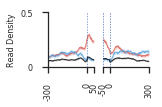

In [7]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_ip_density.2pane.svg'
plot_two_panel(incl, excl, bg, mag, 0, 0.5, output_file, "Read Density")

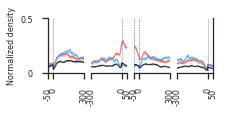

In [8]:
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_ip_density.svg'
plot_four_panel(incl, excl, bg, mag, 0, 0.5, output_file, "Read Density")

In [9]:
# plot_heatmap(_remove_outliers(pd.read_table(hnrnpk_density_included, sep=',', index_col=0)))
# plt.savefig('/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_ip_density.2pane.heatmap.svg')

# Plot RBP map  (Input)

In [10]:
density_dir = '/home/bay001/projects/gabe_qc_20170612/data/'

hnrnpk_density_included = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.3.conf0.95.HNRNPK-BGHLV12-HepG2-included-upon-knockdown.normed_matrix.txt')
hnrnpk_density_excluded = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.3.conf0.95.HNRNPK-BGHLV12-HepG2-excluded-upon-knockdown.normed_matrix.txt')
hnrnpk_density_native_cass = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.3.conf0.95.HepG2_native_cassette_exons.normed_matrix.txt')

In [11]:
density = defaultdict(dict)

density['included'] = {
    'matrix':hnrnpk_density_included,
    'color':density_colors[0]
}
density['excluded'] = {
    'matrix':hnrnpk_density_excluded,
    'color':density_colors[1]
}
density['background'] = {
    'matrix':hnrnpk_density_native_cass,
    'color':density_colors[2]
}

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


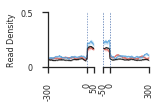

In [12]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_input_density.2pane.svg'

plot_two_panel(incl, excl, bg, mag, 0, 0.5, output_file, "Read Density")

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


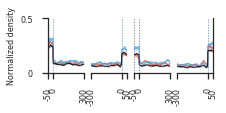

In [13]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_input_density.svg'

plot_four_panel(incl, excl, bg, mag, 0, 0.5, output_file, "Read Density")

In [14]:
# plot_heatmap(_remove_outliers(pd.read_table(hnrnpk_density_included, sep=',', index_col=0)))
# plt.savefig('/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_input_density.2pane.heatmap.svg')

# Now plot the normalized version

In [15]:
density_dir = '/home/bay001/projects/gabe_qc_20170612/data/'
hnrnpk_density_included = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.1.conf0.95.HNRNPK-BGHLV12-HepG2-included-upon-knockdown.normed_matrix.txt')
hnrnpk_density_excluded = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.1.conf0.95.HNRNPK-BGHLV12-HepG2-excluded-upon-knockdown.normed_matrix.txt')
hnrnpk_density_native_cass = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.1.conf0.95.HepG2_native_cassette_exons.normed_matrix.txt')

In [16]:
density = defaultdict(dict)

density['included'] = {
    'matrix':hnrnpk_density_included,
    'color':density_colors[0]
}
density['excluded'] = {
    'matrix':hnrnpk_density_excluded,
    'color':density_colors[1]
}
density['background'] = {
    'matrix':hnrnpk_density_native_cass,
    'color':density_colors[2]
}

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


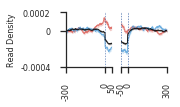

In [17]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_subtract_density.2pane.svg'

plot_two_panel(incl, excl, bg, mag, -0.0004, 0.0002, output_file, "Read Density")

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


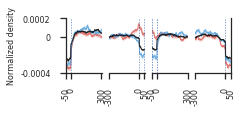

In [18]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_subtract_density.svg'

plot_four_panel(incl, excl, bg, mag, -0.0004, 0.0002, output_file, "Read Density")

In [19]:
# plot_heatmap(_remove_outliers(pd.read_table(hnrnpk_density_included, sep=',', index_col=0)))
# plt.savefig('/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_subtract_density.2pane.heatmap.svg')

# Plot the entropy normalized version

In [20]:
density_dir = '/home/bay001/projects/gabe_qc_20170612/data/'
hnrnpk_density_included = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.2.conf0.95.HNRNPK-BGHLV12-HepG2-included-upon-knockdown.normed_matrix.txt')
hnrnpk_density_excluded = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.2.conf0.95.HNRNPK-BGHLV12-HepG2-excluded-upon-knockdown.normed_matrix.txt')
hnrnpk_density_native_cass = os.path.join(density_dir, '206_01_HNRNPK.merged.r2.2.conf0.95.HepG2_native_cassette_exons.normed_matrix.txt')

In [21]:
density = defaultdict(dict)

density['included'] = {
    'matrix':hnrnpk_density_included,
    'color':density_colors[0]
}
density['excluded'] = {
    'matrix':hnrnpk_density_excluded,
    'color':density_colors[1]
}
density['background'] = {
    'matrix':hnrnpk_density_native_cass,
    'color':density_colors[2]
}

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


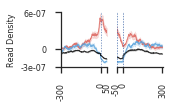

In [22]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_entropy_density.2pane.svg'

plot_two_panel(incl, excl, bg, mag, -0.0000003, 0.0000006, output_file, "Read Density")

((860, 1400), 'Included upon knockdown (860 events)')
((523, 1400), 'Excluded upon knockdown (523 events)')
((2555, 1400), 'Native cassettes (2555 events)')


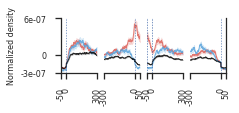

In [23]:
# plot once with the axes labels
incl, excl, bg = get_lines(density)
output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_entropy_density.svg'

plot_four_panel(incl, excl, bg, mag, -0.0000003, 0.0000006, output_file, "Read Density")

In [24]:
# plot_heatmap(_remove_outliers(pd.read_table(hnrnpk_density_included, sep=',', index_col=0)))
# plt.savefig('/home/bay001/projects/gabe_qc_20170612/analysis/206_01_HNRNPK_normalized_entropy_density.2pane.heatmap.svg')

# 11/10 changes
- Plot accompanying heatmaps
    - see above plot_heatmap() function 